## Breast Cancer Prediction using classification models

In [91]:
#importing Libraries
import numpy as np                # For mathematical calculations
import pandas as pd
import sklearn as sp              # For plotting graphs
import matplotlib.pyplot as plt   # For data visualization
import seaborn as sns             # For data visualization

In [92]:
# 1. Data Collection
df = pd.read_csv('train_main.csv')

In [93]:
    #remove unnamed dummy collumn
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [94]:
    #Viewing data
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [95]:
    # Checking Data consistency
print(df.isnull().sum())

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


As seen all Data entries are consistent.

In [96]:
# Dropping data with duplicate information
df = df.drop(['id','radius_se', 'texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst'], axis = 1)

In [97]:
#df.rename(columns=lambda x: x.split(':')[0], inplace=True)
df.columns = ['diagnosis','radius','texture','perimeter','area','smoothness','compactness','concavity','concave_points','symmetry','fractal_dimension']

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
diagnosis            569 non-null object
radius               569 non-null float64
texture              569 non-null float64
perimeter            569 non-null float64
area                 569 non-null float64
smoothness           569 non-null float64
compactness          569 non-null float64
concavity            569 non-null float64
concave_points       569 non-null float64
symmetry             569 non-null float64
fractal_dimension    569 non-null float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


In [99]:
# Univariate Analysis
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [100]:
# Normalizing Diagnosis: scaling values from 0 to 1 instead of number
df['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

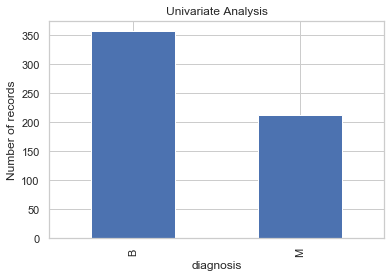

In [101]:
plt.xlabel('diagnosis')
plt.ylabel('Number of records')
plt.title('Univariate Analysis')
df['diagnosis'].value_counts().plot.bar()
plt.show()

# Analysis for independent variables

In [102]:
sns.set(style="whitegrid")

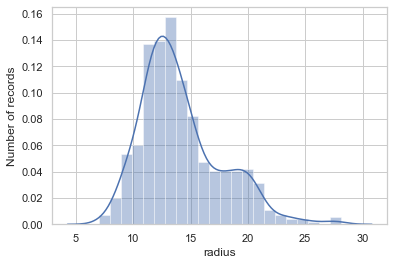

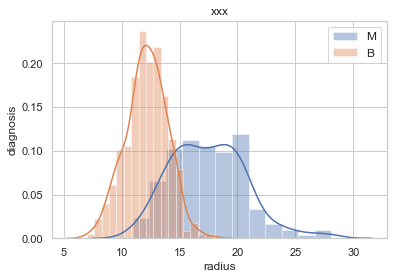

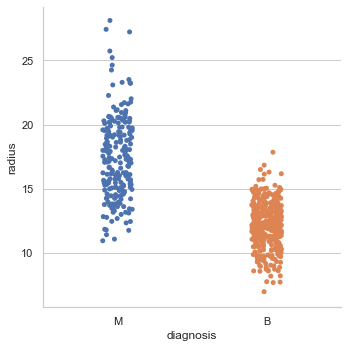

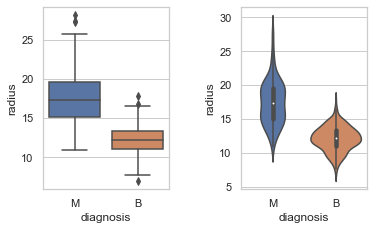

In [114]:
#1
sns.distplot(df['radius'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['radius'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['radius'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('radius')
plt.ylabel('diagnosis')

sns.catplot(x='diagnosis',y='radius',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='radius',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='radius',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

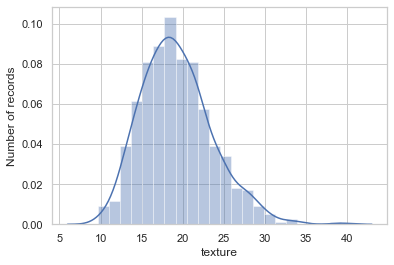

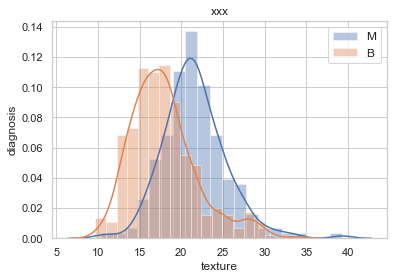

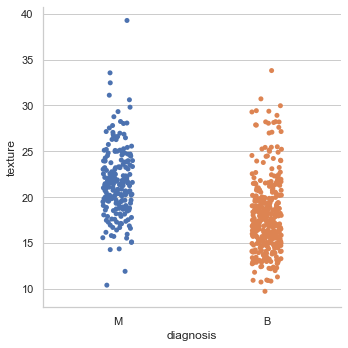

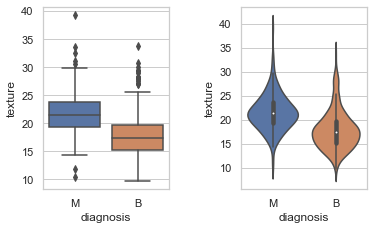

In [115]:
#2
sns.distplot(df['texture'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['texture'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['texture'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('texture')
plt.ylabel('diagnosis')

sns.catplot(x='diagnosis',y='texture',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='texture',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='texture',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

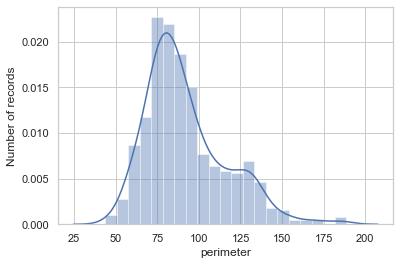

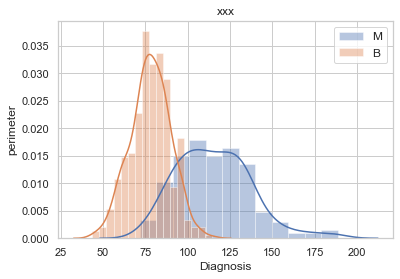

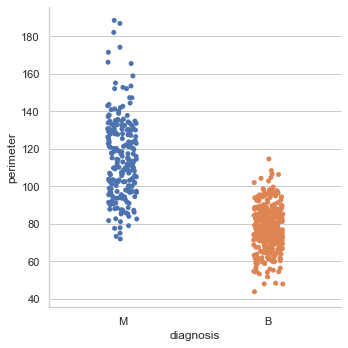

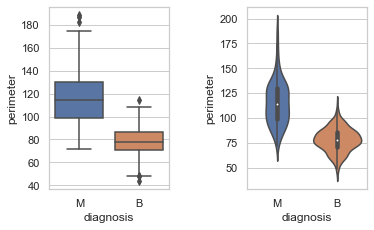

In [105]:
#3
sns.distplot(df['perimeter'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['perimeter'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['perimeter'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('perimeter')

sns.catplot(x='diagnosis',y='perimeter',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='perimeter',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='perimeter',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

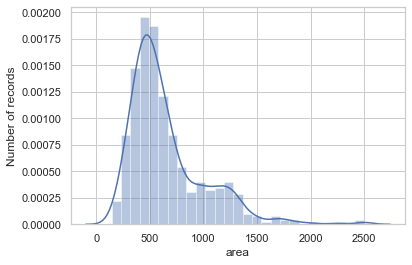

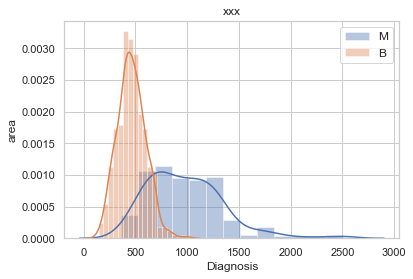

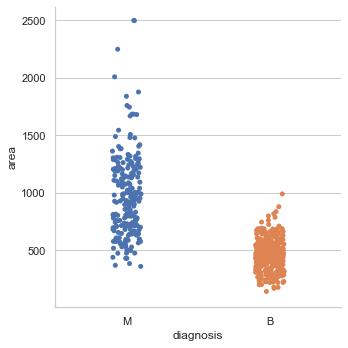

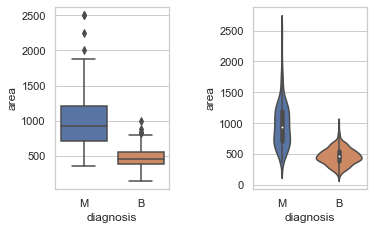

In [106]:
#4
sns.distplot(df['area'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['area'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['area'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('area')

sns.catplot(x='diagnosis',y='area',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='area',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='area',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

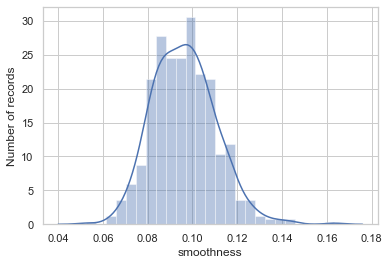

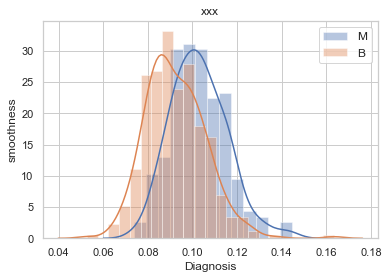

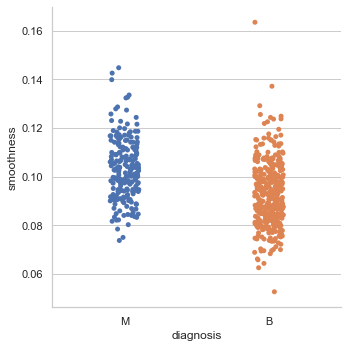

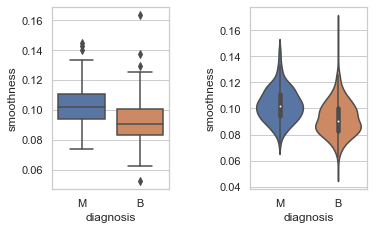

In [107]:
sns.distplot(df['smoothness'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['smoothness'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['smoothness'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('smoothness')

sns.catplot(x='diagnosis',y='smoothness',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='smoothness',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='smoothness',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

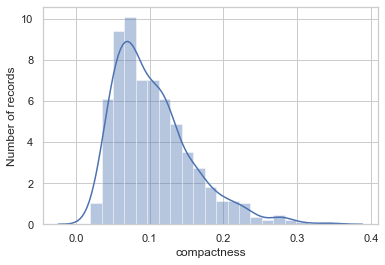

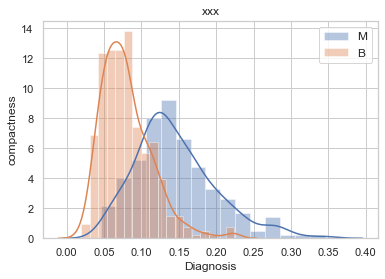

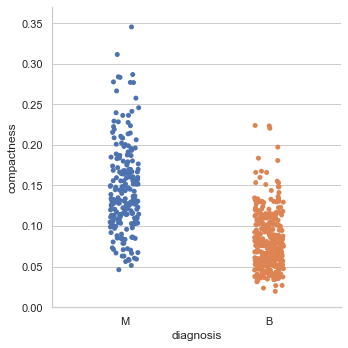

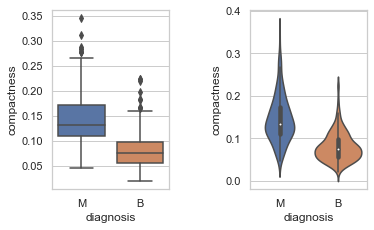

In [108]:
sns.distplot(df['compactness'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['compactness'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['compactness'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('compactness')

sns.catplot(x='diagnosis',y='compactness',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='compactness',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='compactness',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

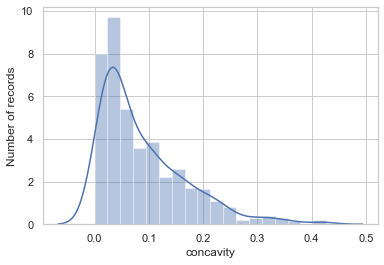

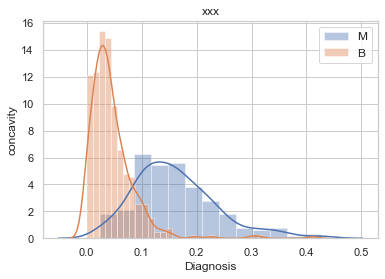

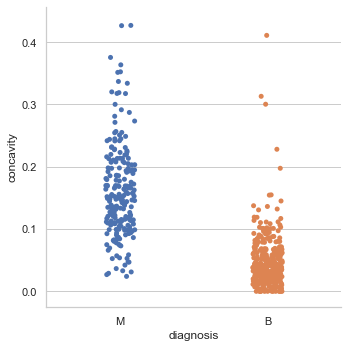

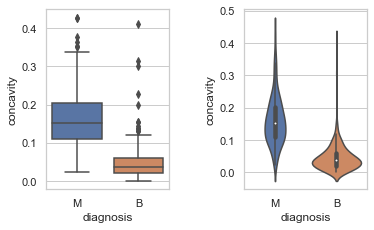

In [109]:
sns.distplot(df['concavity'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['concavity'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['concavity'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('concavity')

sns.catplot(x='diagnosis',y='concavity',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='concavity',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='concavity',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

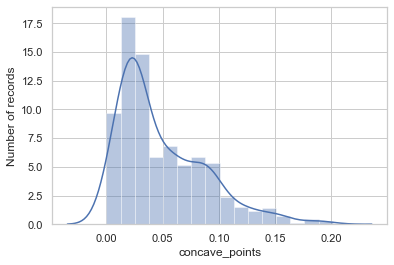

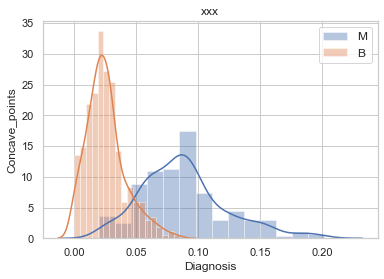

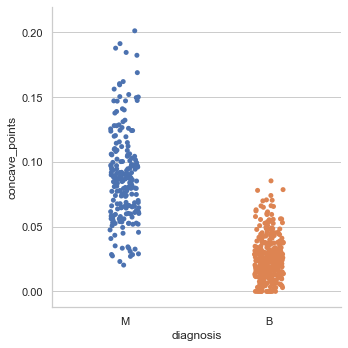

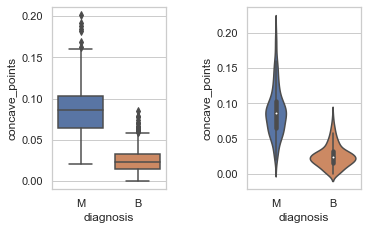

In [110]:
sns.distplot(df['concave_points'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['concave_points'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['concave_points'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('Concave_points')

sns.catplot(x='diagnosis',y='concave_points',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='concave_points',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='concave_points',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

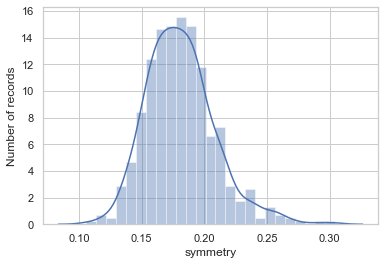

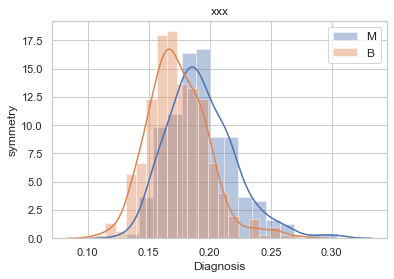

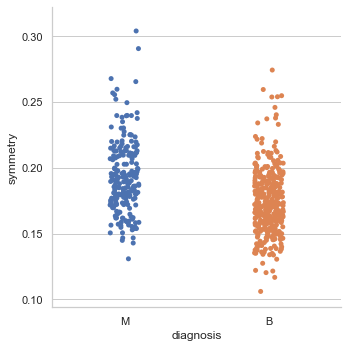

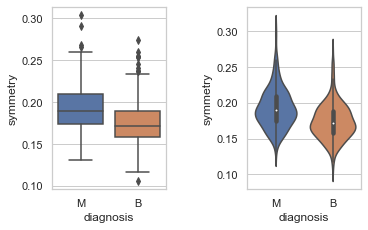

In [111]:
sns.distplot(df['symmetry'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['symmetry'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['symmetry'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('symmetry')

sns.catplot(x='diagnosis',y='symmetry',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='symmetry',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='symmetry',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

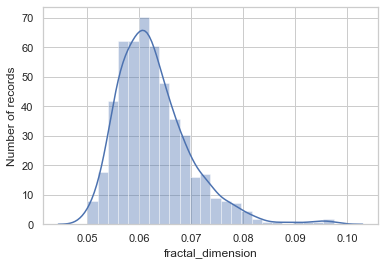

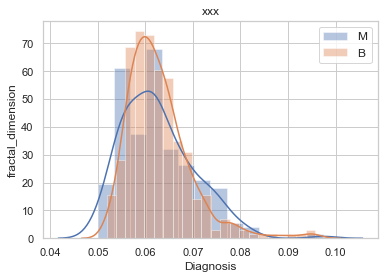

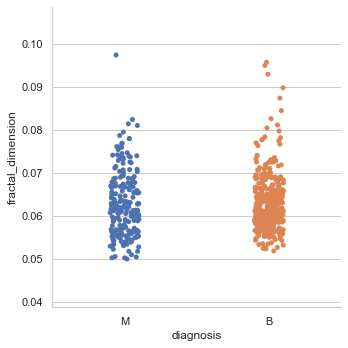

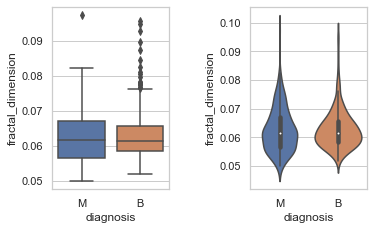

In [112]:
sns.distplot(df['fractal_dimension'])
plt.ylabel('Number of records')
plt.show()

hist = df[df.diagnosis == 'M']
sns.distplot(hist['fractal_dimension'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['fractal_dimension'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('Diagnosis')
plt.ylabel('fractal_dimension')

sns.catplot(x='diagnosis',y='fractal_dimension',data=df)

f, axes = plt.subplots(1, 2)
sns.boxplot(x='diagnosis',y='fractal_dimension',data=df, ax=axes[0])
sns.violinplot(x='diagnosis',y='fractal_dimension',data=df, ax=axes[1])
f.tight_layout(pad=3.0)

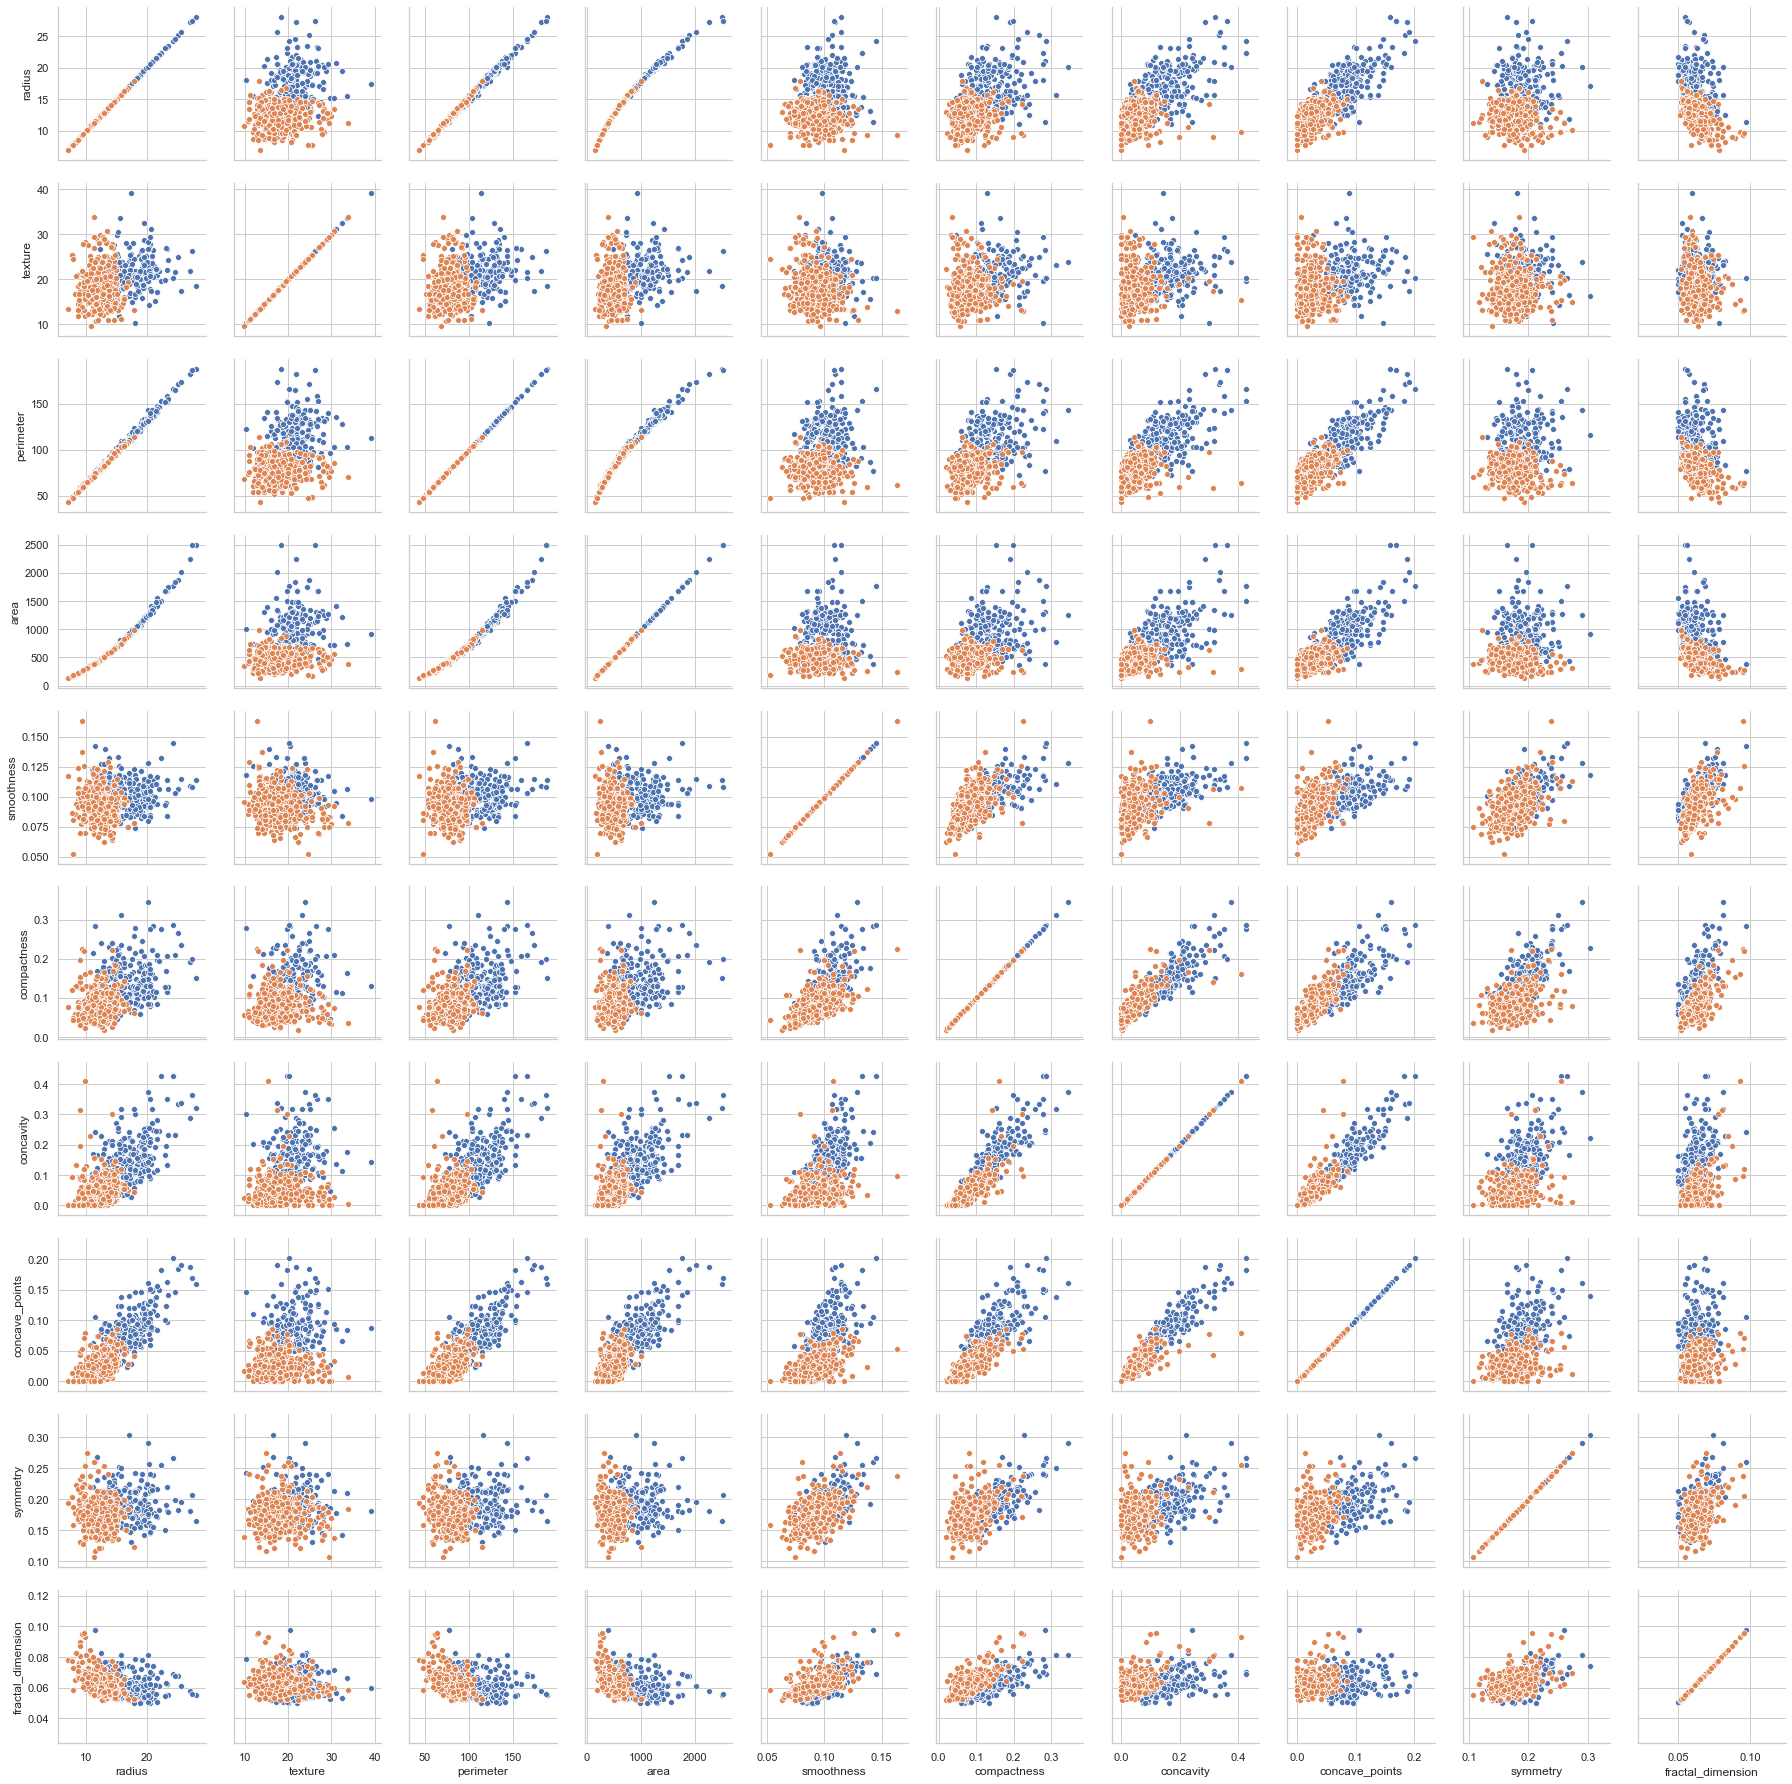

In [113]:
g = sns.PairGrid(df, hue='diagnosis')
g = g.map(sns.scatterplot)
plt.show()

## Data Preprocessing

## Modelling